# COMP258 F24 Group Project

## SETUP

In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.utils import resample
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

from data_map import SKIP_ROWS, METADATA, VALUE_MAPPINGS, NUMERIC_RANGES
from utils import DATA_RAW_PATH, DATA_PATH, BASE_MODEL_PATH

2024-12-06 18:10:48.864667: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 18:10:48.880542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 18:10:48.895507: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 18:10:48.899150: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 18:10:48.910205: I tensorflow/core/platform/cpu_feature_guar

In [2]:
seed = 38 # Global random seed

## DATA PREPARATION

### Load

In [3]:
# Read column names from metadata
features = METADATA["independent_variables"]
labels = METADATA["dependent_variable"]
cat_features = [k for k in VALUE_MAPPINGS.keys()]
num_features = [f for f in features if f not in cat_features]
columns = features + [labels]
columns

['First Term Gpa',
 'Second Term Gpa',
 'First Language',
 'Funding',
 'School',
 'Fast Track',
 'Coop',
 'Residency',
 'Gender',
 'Previous Education',
 'Age Group',
 'High School Average Mark',
 'Math Score',
 'English Grade',
 'FirstYearPersistence']

In [4]:
# Load data
raw = pd.read_csv(DATA_RAW_PATH, names=columns,
                  skiprows=SKIP_ROWS, na_values='?')
raw.head()

,First Term Gpa,Second Term Gpa,First Language,Funding,School,Fast Track,Coop,Residency,Gender,Previous Education,Age Group,High School Average Mark,Math Score,English Grade,FirstYearPersistence
0,0.000000,0.000000,1.0,2,6,2,1,1,2,1.0,1.0,59.0,16.0,7.0,1
1,2.500000,2.000000,3.0,4,6,1,2,2,2,1.0,3.0,NaN,NaN,7.0,1
2,4.250000,3.923077,1.0,1,6,2,1,1,1,2.0,3.0,92.0,41.0,9.0,1
3,3.020833,2.321429,3.0,4,6,1,2,2,2,2.0,3.0,NaN,NaN,8.0,1
4,4.275000,4.326923,1.0,2,6,1,1,1,1,2.0,3.0,97.0,NaN,9.0,1


### Explore

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1437 entries, 0 to 1436
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   First Term Gpa            1420 non-null   float64
 1   Second Term Gpa           1277 non-null   float64
 2   First Language            1326 non-null   float64
 3   Funding                   1437 non-null   int64  
 4   School                    1437 non-null   int64  
 5   Fast Track                1437 non-null   int64  
 6   Coop                      1437 non-null   int64  
 7   Residency                 1437 non-null   int64  
 8   Gender                    1437 non-null   int64  
 9   Previous Education        1433 non-null   float64
 10  Age Group                 1433 non-null   float64
 11  High School Average Mark  694 non-null    float64
 12  Math Score                975 non-null    float64
 13  English Grade             1392 non-null   float64
 14  FirstYea

In [6]:
raw.describe()  # statistics

,First Term Gpa,Second Term Gpa,First Language,Funding,School,Fast Track,Coop,Residency,Gender,Previous Education,Age Group,High School Average Mark,Math Score,English Grade,FirstYearPersistence
count,1420.000000,1277.000000,1326.000000,1437.000000,1437.0,1437.000000,1437.000000,1437.000000,1437.000000,1433.000000,1433.000000,694.000000,975.000000,1392.000000,1437.000000
mean,2.846073,2.820176,1.911011,2.926931,6.0,1.741823,1.695198,1.406402,1.774530,1.274948,2.631542,77.152738,32.557949,8.030172,0.791928
std,1.175098,1.128632,0.994892,1.257658,0.0,0.437784,0.460484,0.491332,0.419699,0.567799,1.421467,12.072760,10.709458,1.716150,0.406070
min,0.000000,0.000000,1.000000,1.000000,6.0,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,17.000000,6.000000,1.000000,0.000000
25%,2.250000,2.260000,1.000000,2.000000,6.0,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,70.000000,23.000000,7.000000,1.000000
50%,3.102632,3.027778,1.000000,2.000000,6.0,2.000000,2.000000,1.000000,2.000000,1.000000,3.000000,77.500000,32.000000,8.000000,1.000000
75%,3.739130,3.680000,3.000000,4.000000,6.0,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,85.000000,43.000000,9.000000,1.000000
max,4.500000,4.500000,3.000000,9.000000,6.0,2.000000,2.000000,2.000000,3.000000,2.000000,8.000000,108.000000,50.000000,10.000000,1.000000


In [7]:
# Check the balanceness of the classes
raw[labels].value_counts()

FirstYearPersistence
1    1138
0     299
Name: count, dtype: int64

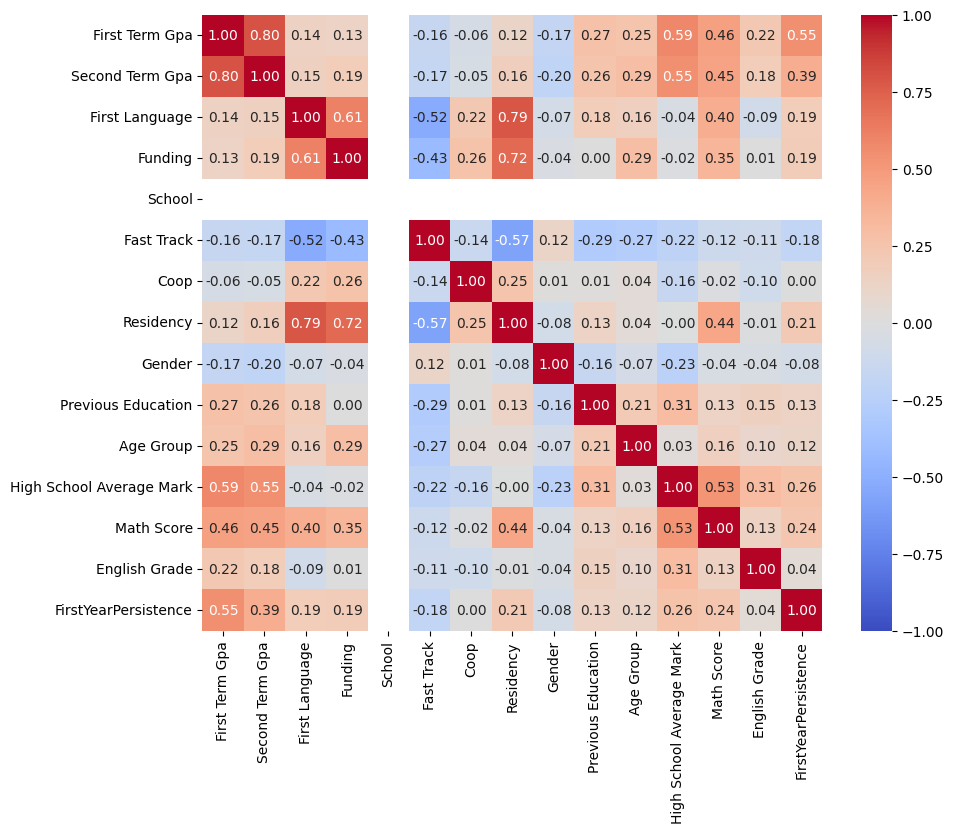

In [8]:
# Plot correlation heatmap
def corr_heat(data):
    corr = data.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
    plt.show()

corr_heat(raw)

### Clean

#### Dropna

In [9]:
# Drop features having small nan, weak correlation and categorical
dropped = raw.dropna(
    subset=["Previous Education", "Age Group", 'First Language', 'English Grade'])
dropped.count()

First Term Gpa              1268
Second Term Gpa             1141
First Language              1284
Funding                     1284
School                      1284
Fast Track                  1284
Coop                        1284
Residency                   1284
Gender                      1284
Previous Education          1284
Age Group                   1284
High School Average Mark     665
Math Score                   875
English Grade               1284
FirstYearPersistence        1284
dtype: int64

#### Imputation

In [10]:
# IterativeImputer for missing numeric values
imputer = IterativeImputer(
    estimator=RandomForestRegressor(),
    max_iter=10,
    n_nearest_features=6, # speed up and prevent overfitting
    imputation_order="ascending", # start from fewer missing features
    tol=1,  # tolerance of the stopping condition.
    random_state=seed)

In [11]:
# Perform imputation
imputed = imputer.fit_transform(dropped)

#### Resample

In [12]:
# Transform to dataframe
imputed_df = pd.DataFrame(imputed, columns=columns)
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1284 entries, 0 to 1283
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   First Term Gpa            1284 non-null   float64
 1   Second Term Gpa           1284 non-null   float64
 2   First Language            1284 non-null   float64
 3   Funding                   1284 non-null   float64
 4   School                    1284 non-null   float64
 5   Fast Track                1284 non-null   float64
 6   Coop                      1284 non-null   float64
 7   Residency                 1284 non-null   float64
 8   Gender                    1284 non-null   float64
 9   Previous Education        1284 non-null   float64
 10  Age Group                 1284 non-null   float64
 11  High School Average Mark  1284 non-null   float64
 12  Math Score                1284 non-null   float64
 13  English Grade             1284 non-null   float64
 14  FirstYea

In [13]:
# Set sub dataframe for 2 classes
major_df = imputed_df[imputed_df[labels] == 1]
minor_df = imputed_df[imputed_df[labels] == 0]

# upsample the minor class
minor_upsampled = resample(minor_df,
                           replace=True,
                           n_samples=len(major_df),
                           random_state=seed)

resampled_df = pd.concat([major_df, minor_upsampled])
resampled_df[labels].value_counts()

FirstYearPersistence
1.0    1014
0.0    1014
Name: count, dtype: int64

### Save

In [14]:
# save data
resampled_df.to_csv(DATA_PATH, index=False)

In [15]:
# reload
data = pd.read_csv(DATA_PATH)
data.head()

,First Term Gpa,Second Term Gpa,First Language,Funding,School,Fast Track,Coop,Residency,Gender,Previous Education,Age Group,High School Average Mark,Math Score,English Grade,FirstYearPersistence
0,0.000000,0.000000,1.0,2.0,6.0,2.0,1.0,1.0,2.0,1.0,1.0,59.00,16.00,7.0,1.0
1,2.500000,2.000000,3.0,4.0,6.0,1.0,2.0,2.0,2.0,1.0,3.0,72.71,29.51,7.0,1.0
2,4.250000,3.923077,1.0,1.0,6.0,2.0,1.0,1.0,1.0,2.0,3.0,92.00,41.00,9.0,1.0
3,3.020833,2.321429,3.0,4.0,6.0,1.0,2.0,2.0,2.0,2.0,3.0,77.27,34.85,8.0,1.0
4,4.275000,4.326923,1.0,2.0,6.0,1.0,1.0,1.0,1.0,2.0,3.0,97.00,41.28,9.0,1.0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2028 entries, 0 to 2027
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   First Term Gpa            2028 non-null   float64
 1   Second Term Gpa           2028 non-null   float64
 2   First Language            2028 non-null   float64
 3   Funding                   2028 non-null   float64
 4   School                    2028 non-null   float64
 5   Fast Track                2028 non-null   float64
 6   Coop                      2028 non-null   float64
 7   Residency                 2028 non-null   float64
 8   Gender                    2028 non-null   float64
 9   Previous Education        2028 non-null   float64
 10  Age Group                 2028 non-null   float64
 11  High School Average Mark  2028 non-null   float64
 12  Math Score                2028 non-null   float64
 13  English Grade             2028 non-null   float64
 14  FirstYea

## INPUT PIPELINE

### Prepare

In [17]:
# Column defualts
column_defaults = [
    tf.constant([0.0], dtype=tf.float32) for _ in range(len(columns))]
column_defaults

I0000 00:00:1733537452.693675   64777 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733537452.705658   64777 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733537452.705704   64777 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733537452.710104   64777 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733537452.710138   64777 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Tensor: shape=(1,), 

In [18]:
# Column indices for numeric and categorical features
num_inx = [columns.index(col) for col in num_features]
cat_inx = [columns.index(col) for col in cat_features]
num_inx, cat_inx

([0, 1, 11, 12], [2, 3, 4, 5, 6, 7, 8, 9, 10, 13])

In [19]:
# Get mean and std for numeric data
num_mean = data[num_features].mean().values
num_std = data[num_features].std().values
print(num_mean)
print(num_std)

[ 2.40773218  2.25174006 77.11248006 31.77453024]
[ 1.35948544  1.31326453 11.3561269   9.67549891]


In [20]:
# Number of categrical values
n_cat = [len(VALUE_MAPPINGS[col]) for col in cat_features]
# Number of classes
n_class = 2

### Pipeline

In [21]:
# Process 1 line and return x, y
@tf.function
def preprocess(line):
    fields = tf.io.decode_csv(line, record_defaults=column_defaults)
    # normalize numerical data
    for i in range(len(num_inx)):
        col_inx = num_inx[i]
        mean = num_mean[i]
        std = num_std[i]
        fields[col_inx] = (fields[col_inx] - mean) / std
    # convert categorical data
    for i in range(len(cat_inx)):
        col_inx = cat_inx[i]
        fields[col_inx] = tf.cast(fields[col_inx], tf.int32)
        fields[col_inx] = tf.one_hot(fields[col_inx], depth=n_cat[i])
    # target encoding
    fields[-1] = tf.cast(fields[-1], tf.int32)
    fields[-1] = tf.one_hot(fields[-1], depth=n_class)
    # build x
    x = [tf.reshape(f, [-1]) if f.shape.ndims == 0 else f for f in fields[:-1]]
    x = tf.concat([v for v in x], axis=0)
    y = fields[-1]
    return x, y

In [22]:
# Read csv and return dataset
def csv_reader_dataset(file_paths, n_readers=5, n_read_threads=tf.data.AUTOTUNE,
                       shuffle_buffer_size=1500, batch_size=32):
    dataset = tf.data.Dataset.list_files(file_paths)
    dataset = dataset.interleave(   # use interleave to read data
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1), # skip header
        cycle_length=n_readers, # num of elements to read parallelly
        num_parallel_calls=n_read_threads)  # num of threads
    # shuffle, preprocess, batch, and prefetch
    dataset = dataset.shuffle(shuffle_buffer_size) \
        .map(preprocess, num_parallel_calls=n_read_threads) \
        .batch(batch_size) \
        .prefetch(tf.data.AUTOTUNE)
    return dataset

### Transform

In [23]:
# Read dataset using the pipeline
dataset = csv_reader_dataset(DATA_PATH)

In [24]:
x_batch, y_batch = next(iter(dataset.take(1)))
x_batch[0], y_batch[0]

(<tf.Tensor: shape=(55,), dtype=float32, numpy=
 array([1.2511821 , 1.4378366 , 0.        , 1.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 1.7803184 , 0.69200265, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>)

### Split

In [25]:
# Sizes for splitting
n_batch = len(list(dataset.as_numpy_iterator()))
val_size = int(0.15 * n_batch)
test_size = int(0.15 * n_batch)

# Generate train, val and test sets
train_set = dataset.skip(val_size + test_size)
val_set = dataset.take(val_size)
test_set = dataset.skip(val_size).take(test_size)

2024-12-06 18:10:53.673669: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## TRAIN MODEL

### Search Model

In [26]:
# Define searching parameters
hidden_layer_configs = [[32], [64], [128], [64, 32], [128, 64], [256, 128]]
dropout_rates = [0.2, 0.4, 0.6]

In [27]:
# Function to build model
def build_model(hidden_layers, dropout_rate):
    model = tf.keras.Sequential()
    model.add(Flatten())
    for n_hidden in hidden_layers:
        model.add(Dense(n_hidden, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation='softmax'))
    return model

In [28]:
# Set variables to iterate
best_model = None
best_val_loss = np.inf

# Search best configuration
for n_hidden in hidden_layer_configs:
    for dropout_rate in dropout_rates:
        print(f"Training model with {n_hidden} hidden layers and dropout rate {dropout_rate}")
        model = build_model(n_hidden, dropout_rate)  # build model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(train_set, epochs=10, validation_data=val_set, verbose=0)
        val_loss = history.history['val_loss'][-1]
        if val_loss < best_val_loss:  # update the best variables
            best_val_loss = val_loss
            best_model = model
            print(f"--> Found new best model - hidden layers={n_hidden}; dropout rate={dropout_rate}", end=' ')
            print(f"Validation loss: {val_loss:.4f}")

Training model with [32] hidden layers and dropout rate 0.2


I0000 00:00:1733537454.393532   64837 service.cc:146] XLA service 0x7f192000ad90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733537454.393574   64837 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2024-12-06 18:10:54.411334: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-06 18:10:54.497145: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1733537455.231059   64837 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-12-06 18:10:55.922921: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-06 18:10:55.922975: I tensorflow/core/f

--> Found new best model - hidden layers=[32]; dropout rate=0.2 Validation loss: 0.4332
Training model with [32] hidden layers and dropout rate 0.4


2024-12-06 18:11:04.173067: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:04.173126: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:04.591408: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:04.591463: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:04.790178: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:04.884552: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:04.884608: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

--> Found new best model - hidden layers=[32]; dropout rate=0.4 Validation loss: 0.3879
Training model with [32] hidden layers and dropout rate 0.6


2024-12-06 18:11:09.317388: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:09.317455: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:09.757855: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:09.757911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:09.951332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:09.951397: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:10.040736: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

Training model with [64] hidden layers and dropout rate 0.2


2024-12-06 18:11:14.582148: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:14.582213: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:15.053793: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:15.053846: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:15.239883: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:15.239941: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:15.331721: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is ab

--> Found new best model - hidden layers=[64]; dropout rate=0.2 Validation loss: 0.3163
Training model with [64] hidden layers and dropout rate 0.4


2024-12-06 18:11:19.647571: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:19.647633: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:20.073583: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:20.073639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:20.250872: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:20.250945: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:20.345628: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

Training model with [64] hidden layers and dropout rate 0.6


2024-12-06 18:11:24.761843: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:24.761900: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:25.213597: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:25.213654: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:25.403256: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:25.403315: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:25.498613: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

Training model with [128] hidden layers and dropout rate 0.2


2024-12-06 18:11:30.675245: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:30.675309: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:31.153878: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:31.153938: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:31.343734: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:31.343801: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:31.449308: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

Training model with [128] hidden layers and dropout rate 0.4


2024-12-06 18:11:38.941238: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:38.941314: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:39.424543: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:39.424599: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:39.638195: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:39.638280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:39.738619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

Training model with [128] hidden layers and dropout rate 0.6


2024-12-06 18:11:44.210230: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:44.210314: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:44.644660: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:44.644717: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:44.839862: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:44.839919: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:44.932137: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

Training model with [64, 32] hidden layers and dropout rate 0.2


2024-12-06 18:11:51.171177: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:51.171232: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:51.355467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:51.355526: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:51.445521: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:51.445579: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:51.634422: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

Training model with [64, 32] hidden layers and dropout rate 0.4


2024-12-06 18:11:57.502626: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:57.502687: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:57.943260: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:57.943321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:58.139515: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:11:58.139580: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:11:58.241810: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

Training model with [64, 32] hidden layers and dropout rate 0.6


2024-12-06 18:12:03.801690: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:03.801757: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:04.251366: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:04.251428: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:04.443070: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:04.443128: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:04.540776: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

Training model with [128, 64] hidden layers and dropout rate 0.2


2024-12-06 18:12:13.377284: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:13.377338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:14.093433: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:14.093481: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:14.279522: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:14.279580: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:14.375453: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

Training model with [128, 64] hidden layers and dropout rate 0.4


2024-12-06 18:12:20.458976: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:20.459029: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:20.657574: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:20.657632: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:20.757201: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:20.757257: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:21.069410: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

Training model with [128, 64] hidden layers and dropout rate 0.6


2024-12-06 18:12:26.453999: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:26.454059: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:26.904407: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:27.125567: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:27.125629: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:27.219964: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:27.220022: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

Training model with [256, 128] hidden layers and dropout rate 0.2


2024-12-06 18:12:33.292398: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:33.292472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:33.775678: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:33.775738: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:33.960580: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:33.960635: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:34.051261: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

--> Found new best model - hidden layers=[256, 128]; dropout rate=0.2 Validation loss: 0.2556
Training model with [256, 128] hidden layers and dropout rate 0.4


2024-12-06 18:12:40.330389: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:40.330447: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:40.540028: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:40.540090: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:40.631299: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:40.631356: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:40.852420: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

Training model with [256, 128] hidden layers and dropout rate 0.6


2024-12-06 18:12:49.350312: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:49.821167: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:49.821222: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:50.036330: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:50.036395: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1617439466416798285
2024-12-06 18:12:50.131170: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15719206370131305061
2024-12-06 18:12:50.131225: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

In [29]:
best_model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_15 (Flatten)            │ (None, 55)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,544 (568.54 KB)

 Trainable params: 48,258 (188.51 KB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 96,518 (377.03 KB)

### Build Model

In [30]:
# Use best model and compile
model = best_model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# Set model check point
mc = ModelCheckpoint(BASE_MODEL_PATH, monitor='val_accuracy',
                     mode='max', verbose=1, save_best_only=True)
# Set early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

### Train Model

In [32]:
# Train the model
history = model.fit(train_set.repeat(),
                    epochs=100,
                    validation_data=val_set.repeat(),
                    steps_per_epoch=1000,
                    validation_steps=100,
                    callbacks=[mc, es])

Epoch 1/100
 997/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8996 - loss: 0.2455
Epoch 1: val_accuracy improved from -inf to 0.97344, saving model to ./model/base_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8997 - loss: 0.2453 - val_accuracy: 0.9734 - val_loss: 0.0908
Epoch 2/100
 983/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9436 - loss: 0.1492
Epoch 2: val_accuracy improved from 0.97344 to 0.97531, saving model to ./model/base_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9436 - loss: 0.1491 - val_accuracy: 0.9753 - val_loss: 0.0680
Epoch 3/100
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9543 - loss: 0.1186
Epoch 3: val_accuracy improved from 0.97531 to 0.97656, saving model to ./model/base_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9543 - loss: 0.1186 - val_accuracy: 0.9766 - val_loss: 0.0534
Epoch 4/100
 982/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9641 - loss: 0.0996

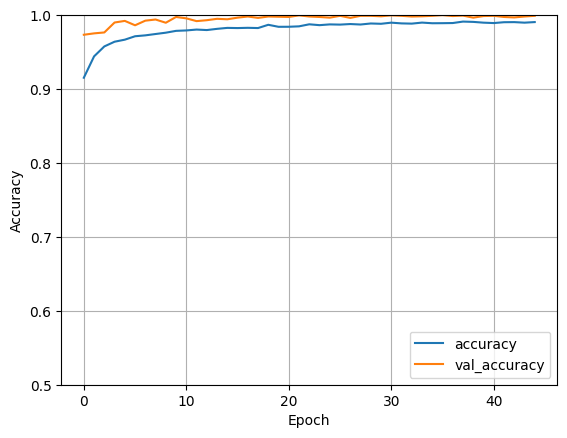

In [33]:
# Plot accuracy history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.gca().set_ylim(0.5, 1)
plt.show()

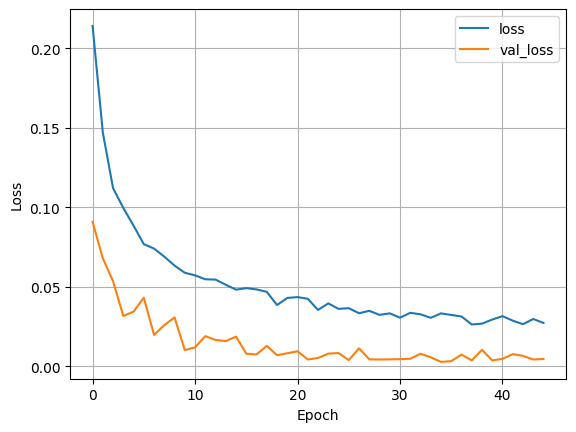

In [34]:
# Plot loss history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

### Evaluate

In [35]:
# load best model
model = tf.keras.models.load_model(BASE_MODEL_PATH)

In [36]:
# Evaluate model
model.evaluate(test_set.repeat(), steps=1000)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9998 - loss: 0.0033


[0.003268422558903694, 0.9997187256813049]

In [37]:
# evaluate confusion matrix
y_true = []
y_pred = []
for x_batch, y_batch in test_set:
    y_true.extend(np.argmax(y_batch.numpy(), axis=1))
    y_pred.extend(np.argmax(model.predict(x_batch), axis=1))
cm = tf.math.confusion_matrix(y_true, y_pred)
cm

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[147,   0],
       [  0, 141]], dtype=int32)>

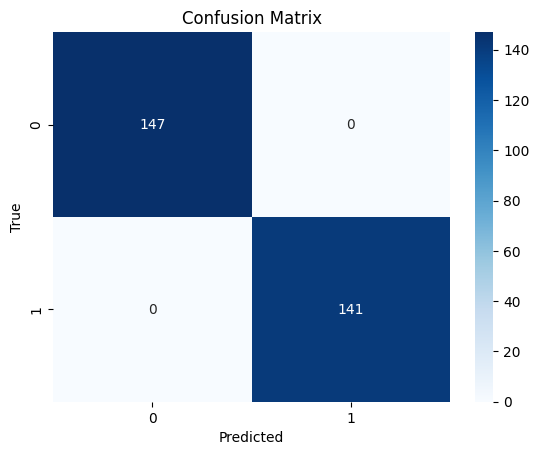

In [38]:
# plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

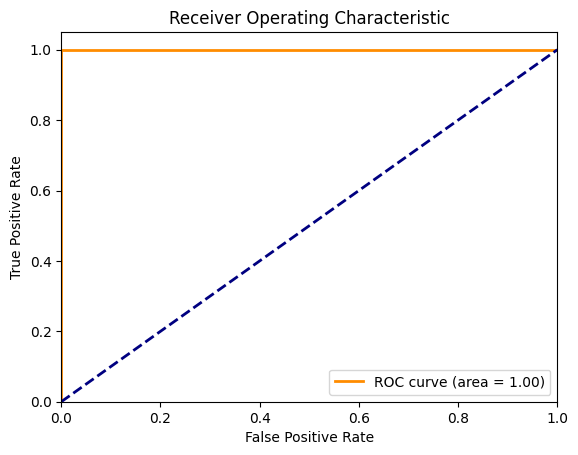

In [39]:
# plot auc
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()